# Exploring Structural Tensor Implementation - Method Validation
## Sam Potter
## Current: 4/12/19

## Paths and Imports

In [1]:
import sys
import os

# psfdi
sys.path.extend(['C:\\Users\\potterst1\\Desktop\Repositories\BitBucket\psfdi',
                 'C:/Users/potterst1/Desktop/Repositories/BitBucket/psfdi'])
sys.path.extend(['/workspace/stpotter/git/bitbucket/psfdi'])

from psfdi import visualize
from psfdi import fileIO
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import patches
from matplotlib import rc
from psfdi import utilities
from psfdi import odf
from psfdi import image_processing as imp
import seaborn as sns
import cv2
import matplotlib

from ipywidgets import *
from scipy import optimize as sciopt
from scipy.stats import beta
from scipy.stats import sem

## Magics

In [2]:
%matplotlib inline

# Synthetic Example

## Create Beta Distribution Data

### Statistics and theta ranges

In [3]:
mean1 = np.deg2rad(5)
sd1 = np.deg2rad(10)
mean2 = np.deg2rad(25)
sd2 = np.deg2rad(30)
theta = np.linspace(-np.pi, np.pi, 360)
d = 0.5
max_order = 15

### Gamma from beta distribution

In [4]:
gamma = odf.compute_gamma(mean1, sd1, mean2, sd2, theta)

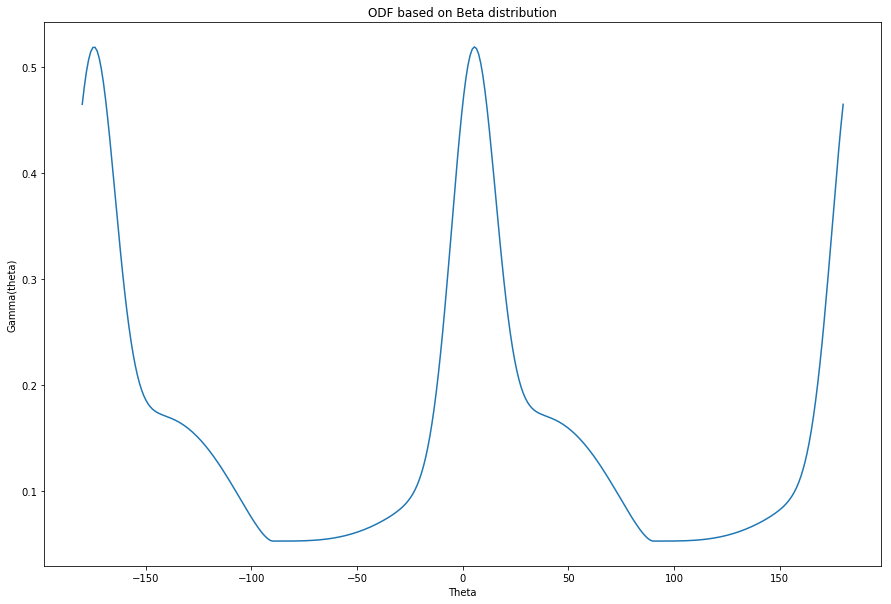

In [5]:
fig = plt.figure(figsize=(15, 10))
plt.plot(np.rad2deg(theta), gamma);
plt.xlabel('Theta')
plt.ylabel('Gamma(theta)')
plt.title('ODF based on Beta distribution');

## Fourier Fitting

### Fitting Functions

### Compute Fourier Fit

In [6]:
an, bn, c = odf.fit_fourier(14, gamma, theta)
gamma_fourier_fit = odf.compute_fourier(an, bn, c, theta)

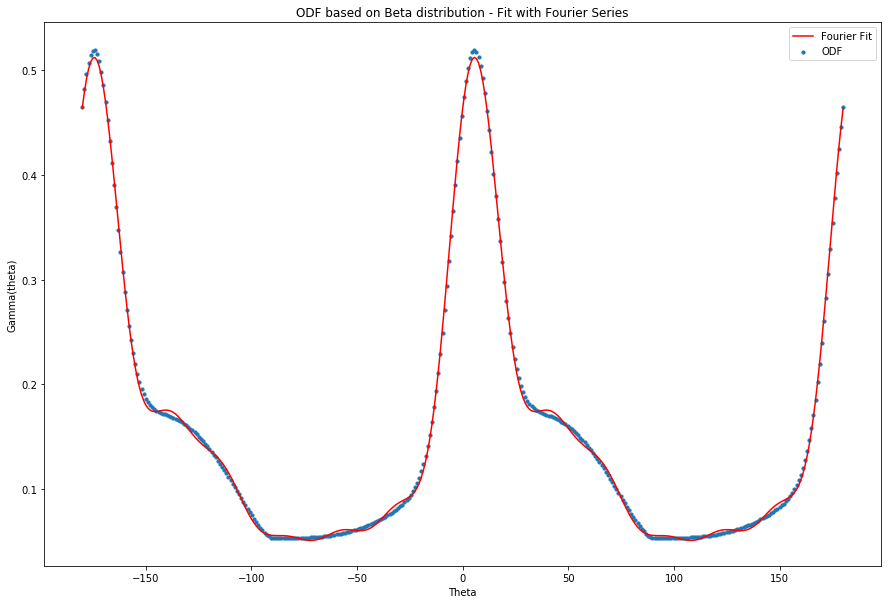

In [7]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(np.rad2deg(theta), gamma, marker='o', s=10, label='ODF');
plt.plot(np.rad2deg(theta), gamma_fourier_fit, color='r', label='Fourier Fit')
plt.xlabel('Theta')
plt.ylabel('Gamma(theta)')
plt.title('ODF based on Beta distribution - Fit with Fourier Series');
plt.legend();

## Structural Tensor

### Form Rank 2 Structural Tensor

In [8]:
D2 = np.array([[an[0], bn[0]],
             [bn[0], -an[0]]])
print(D2)

[[ 0.83607858  0.4167935 ]
 [ 0.4167935  -0.83607858]]


### Compute eigenvectors

In [9]:
eigvals, eigvecs = np.linalg.eig(D2)

In [10]:
eigvals

array([ 0.9342078, -0.9342078])

In [11]:
eigvecs

array([[ 0.97338583, -0.22917246],
       [ 0.22917246,  0.97338583]])

In [12]:
theta1 = np.arctan2(eigvecs[0, 0], eigvecs[0, 1])
theta2 = np.arctan2(eigvecs[1, 0], eigvecs[1, 1])

In [13]:
print('theta I: {}'.format(np.rad2deg(theta1)))
print('theta II: {}'.format(np.rad2deg(theta2)))

theta I: 103.24835609629882
theta II: 13.24835609629881


Something is out of order with the eigenvalues, thus why theta I and theta II are switched

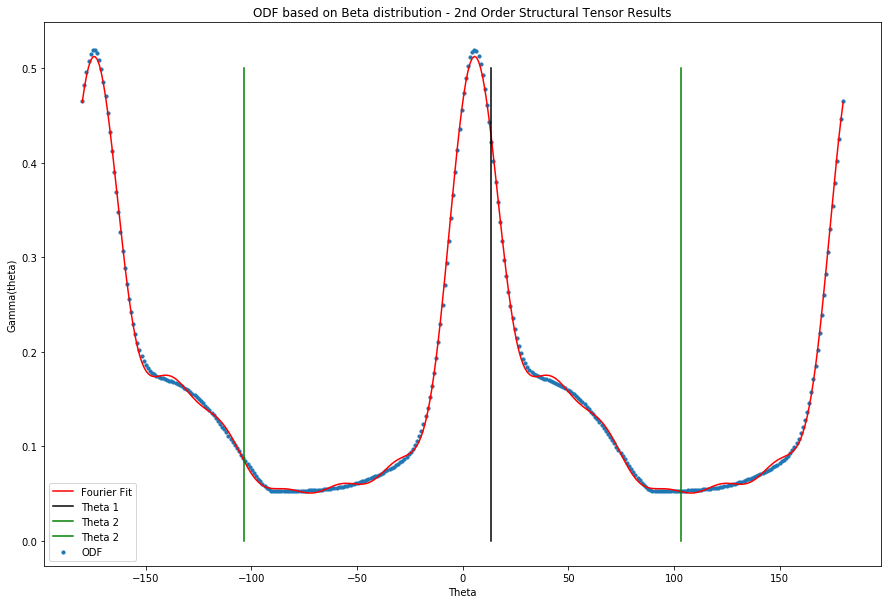

In [14]:
i1plot_theta = np.rad2deg(theta2) * np.ones(100)
i1plot = np.linspace(0, 0.5, 100)

i2plot_theta_plus = np.rad2deg(theta1) * np.ones(100)
i2plot_theta_minus = np.rad2deg(-theta1) * np.ones(100)

i2plot = np.linspace(0, 0.5, 100)

fig = plt.figure(figsize=(15, 10))
plt.scatter(np.rad2deg(theta), gamma, marker='o', s=10, label='ODF');
plt.plot(np.rad2deg(theta), gamma_fourier_fit, color='r', label='Fourier Fit')
plt.plot(i1plot_theta, i1plot, color='k', label='Theta 1')
plt.plot(i2plot_theta_plus, i2plot, color='g', label='Theta 2')
plt.plot(i2plot_theta_minus, i2plot, color='g', label='Theta 2')
plt.xlabel('Theta')
plt.ylabel('Gamma(theta)')
plt.title('ODF based on Beta distribution - 2nd Order Structural Tensor Results');
plt.legend();